# 0. Импорт вспомогательных модулей

In [1]:
import csv
import keras
from keras import layers
from keras import regularizers
import numpy as np
import matplotlib.pyplot as plt


# 1. Подготовка обучающих данных
## 1.1. Выгрузка данных для обучения из файла

In [2]:
def read_from_file(file_name):
    with open(file_name, mode="r", encoding="utf-8") as csvfile:
        reader = csv.DictReader(csvfile)
        features = reader.fieldnames
        read_data = [
            {feature: row[feature] for feature in features} for row in reader
        ]
    return features, read_data


In [3]:
_, read_data = read_from_file("/kaggle/input/titanic/train.csv")
# read_data


## 1.2. Выделение данных и меток для обучения 

In [4]:
np.random.shuffle(read_data)
features_to_use = ("Pclass", "Sex", "Age", "SibSp", "Parch", "Embarked")
train_data_raw = {
    feature: [row[feature] for row in read_data]
    for feature in features_to_use
}
# train_data_raw


## 1.3. Векторизация

In [5]:
def to_one_hot(data, *, master=None):
    encoded_data = data.copy()
    if master:
        categories = sorted(set(master))
    elif not master:
        categories = sorted(set(encoded_data))
    for i, val in enumerate(encoded_data):
        # result = np.zeros(len(categories), dtype="float32")
        result = [0 for _ in categories]
        result[categories.index(val)] = 1
        encoded_data[i] = result
    return encoded_data

def copy_data(data):
    return {key: data[key].copy() for key in data}

def vectorize_data(data, *, master=None, catg_ftrs=("Pclass", "Sex", "Embarked")):
    vectorized_data = copy_data(data)
    cont_ftrs = tuple(
        ftr for ftr in vectorized_data.keys() if ftr not in catg_ftrs
    )
    if master:
        for ftr in catg_ftrs:
            vectorized_data[ftr] = to_one_hot(vectorized_data[ftr],
                                              master=master[ftr])
    elif not master:
        for ftr in catg_ftrs:
            vectorized_data[ftr] = to_one_hot(vectorized_data[ftr])
    for ftr in cont_ftrs:
        for i, val in enumerate(vectorized_data[ftr]):
            try:
                vectorized_data[ftr][i] = float(val)
            except ValueError:
                vectorized_data[ftr][i] = None
    return vectorized_data


train_data_vectorized = vectorize_data(train_data_raw)
# train_data_vectorized

## 1.4. Обработка недостающих значений

In [6]:
def get_median_val(data, ftr, group=None):
    data = copy_data(data)
    if group:
        filtered_data = [
            val for i, val in enumerate(data[ftr])
            if (tuple(data["Pclass"][i]), tuple(data["Sex"][i])) == group
        ]
        sorted_data = sorted([val for val in filtered_data if val != None])
    else:
        sorted_data = sorted([val for val in data[ftr] if val != None])
    if len(sorted_data) % 2 == 0:
        meadian_value = (
            (sorted_data[int(len(sorted_data) / 2)]
             + sorted_data[int(len(sorted_data)/2 + 1)]) / 2
        )
    else:
        meadian_value = sorted_data[int((len(sorted_data) + 1) / 2)]
    return meadian_value

def fill_data(data):
    filled_data = copy_data(data)
    non_empty_count = sum(
            [1 for val in filled_data["Age"] if val != None]
    )
    if non_empty_count < len(filled_data["Age"]):
        median_values = {
            ((1., 0., 0.), (1., 0.)): get_median_val(data, "Age", ((1., 0., 0.), (1., 0.))),    # Pclass: "1", Sex: "female"
            ((1., 0., 0.), (0., 1.)): get_median_val(data, "Age", ((1., 0., 0.), (0., 1.))),    # Pclass: "1", Sex: "male"
            ((0., 1., 0.), (1., 0.)): get_median_val(data, "Age", ((0., 1., 0.), (1., 0.))),    # Pclass: "2", Sex: "female"
            ((0., 1., 0.), (0., 1.)): get_median_val(data, "Age", ((0., 1., 0.), (0., 1.))),    # Pclass: "2", Sex: "male"
            ((0., 0., 1.), (1., 0.)): get_median_val(data, "Age", ((0., 0., 1.), (1., 0.))),    # Pclass: "3", Sex: "female"
            ((0., 0., 1.), (0., 1.)): get_median_val(data, "Age", ((0., 0., 1.), (0., 1.))),    # Pclass: "3", Sex: "male"
        }
        for i, val in enumerate(filled_data["Age"]):
            if not val:
                filled_data["Age"][i] = median_values[
                    (tuple(filled_data["Pclass"][i]) , tuple(filled_data["Sex"][i]))
                ]
    return filled_data



train_data_filled = fill_data(train_data_vectorized)
# train_data_filled["Age"]

## 1.5. Конструирование признаков

In [7]:
def add_features(data):
    data = copy_data(data)
    result = {"AgeGrp": []}
    for val in data["Age"]:
        if 0 <= val < 10:
            result["AgeGrp"].append(0.)
        elif 10 <= val < 20:
            result["AgeGrp"].append(1.)
        elif 20 <= val < 30:
            result["AgeGrp"].append(2.)
        elif 30 <= val < 40:
            result["AgeGrp"].append(3.)
        elif 40 <= val < 50:
            result["AgeGrp"].append(4.)
        elif 50 <= val < 60:
            result["AgeGrp"].append(5.)
        elif 60 <= val < 70:
            result["AgeGrp"].append(6.)
        elif 70 <= val:
            result["AgeGrp"].append(7.)
    result["AgeGrp"] = to_one_hot(result["AgeGrp"])
    data.update(result)
    return data


train_data_upgraded = add_features(train_data_filled)
# train_data_upgraded

## 1.6. Нормализация значений

In [8]:
def normalize_data(data, *, master=None):
    normalized_data = copy_data(data)
    if master:
        master_data = copy_data(master)
    elif not master:
        master_data = copy_data(data)
    cont_ftrs = ("Age", "Parch", "SibSp")
    for ftr in cont_ftrs:
        mean_val = (
            sum([val for val in master_data[ftr] if val])
            / len(master_data[ftr])
        )
        std_dev = np.sqrt(
            sum([(val - mean_val)**2 for val in master_data[ftr]
                 if val]) / len(master_data[ftr])
        )
        for i, _ in enumerate(normalized_data[ftr]):
            normalized_data[ftr][i] -= mean_val
            normalized_data[ftr][i] = [normalized_data[ftr][i] / std_dev]
    return normalized_data
    

train_data_normalized = normalize_data(train_data_upgraded)
# train_data_normalized


## 1.7. Формирование массивов данных для обучения

In [9]:
train_data = {
    ftr: np.array(train_data_normalized[ftr].copy(), dtype="float32")
    for ftr in train_data_normalized
}
train_labels = np.array([row["Survived"] for row in read_data], dtype="float32")
# train_data


# 2. Обучение модели
## 2.1. Валидация

In [10]:
def build_model():
    num_of_neurons = 64
    num_of_layers = 2
    dropout_ratio = .50
    inputs = [
        keras.Input(shape=(train_data[ftr].shape[1], ), name=ftr)
        for ftr in train_data
    ]
    features = layers.Concatenate()(inputs)
    for i in range(num_of_layers):
        features = layers.Dense(int(num_of_neurons / 2**i),
                                activation="relu",
                                name=f"Dense{i+1}")(features)
        features = layers.Dropout(dropout_ratio, name=f"Dropout{i+1}")(features)
    outputs = layers.Dense(1, activation="sigmoid", name="Output")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    # model.summary()
    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=5.0e-3),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model


k = 10
num_of_val_samples = len(train_labels) // k
num_of_epochs = 300
validation_losses = []
validation_accuracies = []
batch_size = 128
callback = keras.callbacks.EarlyStopping(patience=5, 
                                         # restore_best_weights=True, 
                                         start_from_epoch=10)
for i in range(k):
    print(f"Processing fold #{i+1} out of {k}...")
    val_data = {}
    train_data_partial = {}
    for ftr in train_data:
        val_data.update(
            {ftr:
             train_data[ftr][i*num_of_val_samples:(i+1)*num_of_val_samples]}
        )
        train_data_partial.update(
            {ftr:
             np.concatenate(
                 [train_data[ftr][:i*num_of_val_samples],
                  train_data[ftr][(i+1)*num_of_val_samples:]]
             )}
        )
    val_labels = train_labels[i*num_of_val_samples:(i+1)*num_of_val_samples]
    train_labels_partial = np.concatenate(
        [train_labels[:i*num_of_val_samples],
         train_labels[(i+1)*num_of_val_samples:]]
    )
    model = build_model()
    history = model.fit(train_data_partial,
                        train_labels_partial,
                        epochs=num_of_epochs,
                        batch_size=batch_size,
                        validation_data=(val_data, val_labels),
                        verbose=0)
    validation_loss_history = history.history["val_loss"]
    validation_losses.append(validation_loss_history)
    validation_accuracy_history = history.history["val_accuracy"]
    validation_accuracies.append(validation_accuracy_history)
print("Done.")


Processing fold #1 out of 10...
Processing fold #2 out of 10...
Processing fold #3 out of 10...
Processing fold #4 out of 10...
Processing fold #5 out of 10...
Processing fold #6 out of 10...
Processing fold #7 out of 10...
Processing fold #8 out of 10...
Processing fold #9 out of 10...
Processing fold #10 out of 10...
Done.


## 2.2. Визуализация результатов валидации

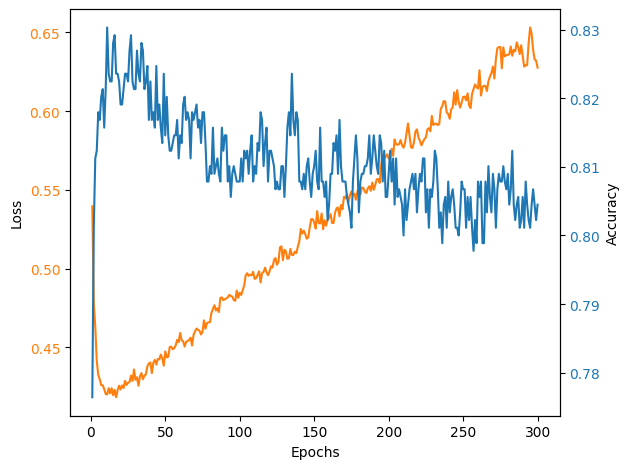

In [11]:
validation_losses_average = [
    np.mean([val_los[i] for val_los in validation_losses])
    for i in range(num_of_epochs)
]
validation_accuracies_average = [
    np.mean([val_acc[i] for val_acc in validation_accuracies])
    for i in range(num_of_epochs)
]
fig, ax1 = plt.subplots()
color = "tab:orange"
ax1.plot(
    range(1, num_of_epochs+1), validation_losses_average, color=color
)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.tick_params(axis="y", labelcolor=color)
ax2 = ax1.twinx()
color = "tab:blue"
ax2.plot(
    range(1, num_of_epochs+1), validation_accuracies_average, color=color
)
ax2.set_ylabel("Accuracy")
ax2.tick_params(axis="y", labelcolor=color)
fig.tight_layout()
plt.show()


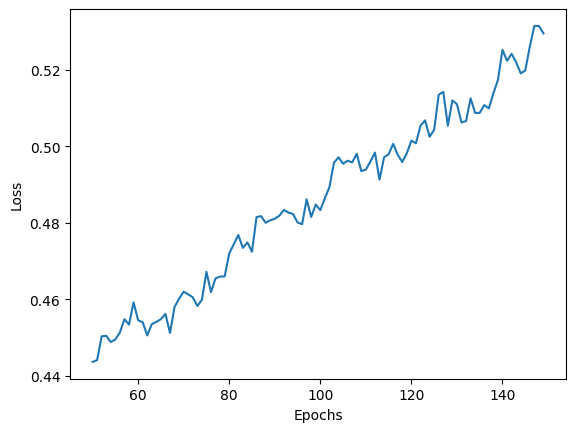

In [12]:
validation_losses_truncated = validation_losses_average[50:150]
plt.plot(range(50,150), validation_losses_truncated)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


## 2.3 Определение эпохи переобучения

In [13]:
oferfitting_epoch = (
    validation_losses_average.index(min(validation_losses_average))
)
oferfitting_epoch


16

In [14]:
validation_accuracies_average[oferfitting_epoch], min(validation_losses_average)

(0.8235954940319061, 0.4183677762746811)

## 2.3. Обучение новой модели

In [15]:
new_model = build_model()
print("Fitting new model...")
new_model.fit(train_data,
              train_labels,
              epochs=oferfitting_epoch,
              batch_size=batch_size,
              verbose=0)
print("New model has been fitted.")


Fitting new model...
New model has been fitted.


In [16]:
# model.save("/kaggle/working/my_model.keras")

In [17]:
# my_model = keras.models.load_model("/kaggle/working/my_model.keras")

# 3. Подготовка контрольных данных
## 3.1. Выгрузка контрольных данных из файла

In [18]:
_, read_data = read_from_file("/kaggle/input/titanic/test.csv")
# read_data


## 3.2. Выделение контрольных данных

In [19]:
test_data_raw = {
    feature: [row[feature] for row in read_data]
    for feature in features_to_use
}
# test_data_raw


## 3.3. Векторизация

In [20]:
test_data_vectorized = vectorize_data(test_data_raw,
                                      master=train_data_raw)
# test_data_vectorized


## 3.4. Обработка недостающих значений

In [21]:
test_data_filled = fill_data(test_data_vectorized)
# test_data_filled


## 3.5. Конструирование признаков

In [22]:
test_data_upgraded = add_features(test_data_filled)
# test_data_upgraded


## 3.6. Нормализация значений

In [23]:
test_data_normalized = normalize_data(test_data_upgraded,
                                      master=train_data_upgraded)
# test_data_normalized


## 3.7. Формирование массива контрольных данных

In [24]:
test_data = {
    ftr: np.array(test_data_normalized[ftr].copy(), dtype="float32")
    for ftr in test_data_normalized
}
# test_data


# 4. Формирование предсказаний
## 4.1. Получение вероятности выживания

In [25]:
predictions_raw = new_model.predict(test_data, verbose=0)
# predictions_raw


## 4.2. Округление значений до целого

In [26]:
predictions = [
    int(round(prediction[0], 0)) for prediction in predictions_raw
]
# predictions


## 4.3. Запись результатов в файл

In [27]:
with open("/kaggle/working/submission.csv", mode="w", encoding="utf-8", newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=["PassengerId", "Survived"])
    writer.writeheader()
    for i, prediction in enumerate(predictions):
        writer.writerow(
            {
                "PassengerId": read_data[i]["PassengerId"],
                "Survived": prediction
            }
        )
    print("File has been written.")


File has been written.
